# Assignment 2 | Social Graphs course

 Part 1: Network Analysis of Rock Bands wiki-graph using week 5 tools


In [16]:
# Import necessary libraries

# Part 1 and 2 imports
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter

# Part 3 imports
from networkx.algorithms.community import louvain_communities

# Part 4 imports
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
import requests
from bs4 import BeautifulSoup
import time
import json
import urllib.parse

In [3]:
# Load the rock performer graph
G = nx.read_gexf('./rock_performers_graph.gexf')
print("Directed graph - Nodes:", G.number_of_nodes(), "Edges:", G.number_of_edges())

# Convert to undirected for basic analysis
G_undir = G.to_undirected()
print("Undirected - Nodes:", G_undir.number_of_nodes(), "Edges:", G_undir.number_of_edges())


Directed graph - Nodes: 297 Edges: 5164
Undirected - Nodes: 297 Edges: 3611


Average degree: 24.316498316498315


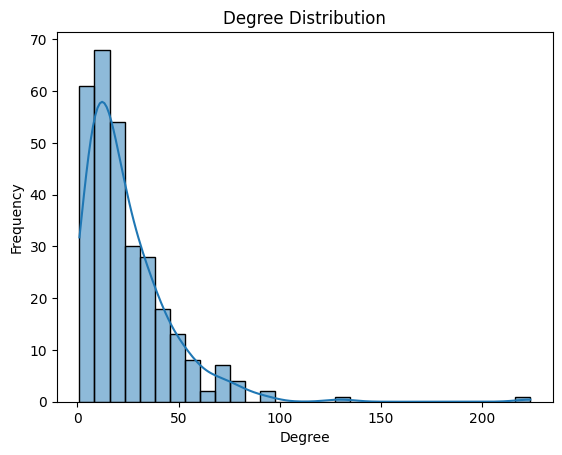

Top 5 Degree centrality: ['Rock_music', 'The_Beatles', 'U2', 'The_Rolling_Stones', 'Bruce_Springsteen']
Top 5 Betweenness centrality: ['Rock_music', 'The_Beatles', 'Bruce_Springsteen', 'U2', 'The_Rolling_Stones']
Top 5 Closeness centrality: ['Rock_music', 'The_Beatles', 'The_Rolling_Stones', 'U2', 'Black_Sabbath']
Top 5 Eigenvector centrality: ['Rock_music', 'The_Beatles', 'The_Rolling_Stones', 'U2', 'The_Who']
Degree assortativity: -0.11478987645742376
Backbone edges: 296


In [4]:
# Basic statistics
avg_degree = sum(dict(G_undir.degree()).values()) / G_undir.number_of_nodes()
print("Average degree:", avg_degree)

# Degree distribution
degrees = [d for n, d in G_undir.degree()]
sns.histplot(degrees, bins=30, kde=True)
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()

# Centrality measures
deg_c = dict(G_undir.degree())
bet_c = nx.betweenness_centrality(G_undir)
clo_c = nx.closeness_centrality(G_undir)
eig_c = nx.eigenvector_centrality(G_undir, max_iter=1000)

# Display top nodes by centrality
for name, centrality in [("Degree", deg_c), ("Betweenness", bet_c), ("Closeness", clo_c), ("Eigenvector", eig_c)]:
    top5 = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:5]
    print(f"Top 5 {name} centrality:", [n for n, _ in top5])

# Assortativity
assort = nx.degree_assortativity_coefficient(G_undir)
print("Degree assortativity:", assort)

# Backbone: Maximum Spanning Tree
wG = G_undir.copy()
deg_dict = dict(G_undir.degree())
for u, v in wG.edges():
    wG[u][v]['weight'] = deg_dict[u] + deg_dict[v]
mst = nx.maximum_spanning_tree(wG)
print("Backbone edges:", mst.number_of_edges())


Part 1 analysis

# Part 2: Community Detection

In [8]:
communities = list(louvain_communities(G_undir, seed=42))
print("Detected communities (sizes):", [len(c) for c in communities])
mod_val = nx.community.modularity(G_undir, communities)
print("Modularity:", mod_val)

# Simulated genre assignments
genre_assign = {
    "The_Beatles": "Classic",
    "Rolling_Stones": "Classic",
    "Metallica": "Metal",
    "Radiohead": "Indie",
    "Green_Day": "Punk"
}
genres = list(set(genre_assign.values()))
comm_labels = {node: i for i, c in enumerate(communities) for node in c}
D = np.zeros((len(genres), len(communities)), dtype=int)
for artist, genre in genre_assign.items():
    if artist in comm_labels:
        D[genres.index(genre), comm_labels[artist]] += 1

print("Genre vs Community matrix:\n", D)

Detected communities (sizes): [49, 48, 74, 43, 83]
Modularity: 0.27225010412735445
Genre vs Community matrix:
 [[0 0 1 0 0]
 [0 0 0 0 0]
 [1 0 0 0 0]
 [0 0 0 0 1]]


Part 2 analysis

# Part 3: TF-IDF and Word Clouds

TF-IDF matrix:
          abba    ac  anthrax  arctic_monkeys  beatles  bee_gees  \
Classic  0.00  0.00     0.00            0.00     0.45      0.00   
Metal    0.00  0.38     0.38            0.00     0.00      0.00   
Indie    0.00  0.00     0.00            0.45     0.00      0.00   
Pop      0.45  0.00     0.00            0.00     0.00      0.45   

         black_sabbath  bob_dylan  coldplay    dc  ...  iron_maiden  madonna  \
Classic           0.00       0.45      0.00  0.00  ...         0.00     0.00   
Metal             0.38       0.00      0.00  0.38  ...         0.38     0.00   
Indie             0.00       0.00      0.45  0.00  ...         0.00     0.00   
Pop               0.00       0.00      0.00  0.00  ...         0.00     0.45   

         metallica  nirvana  pearl_jam  presley  queen  radiohead  \
Classic       0.00     0.00       0.00     0.00   0.45       0.00   
Metal         0.38     0.00       0.00     0.00   0.00       0.00   
Indie         0.00     0.45       0.45  

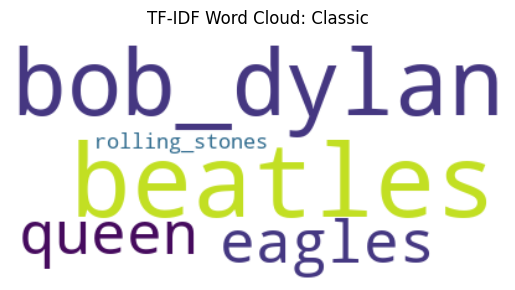

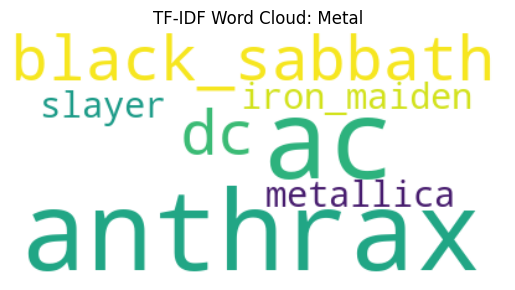

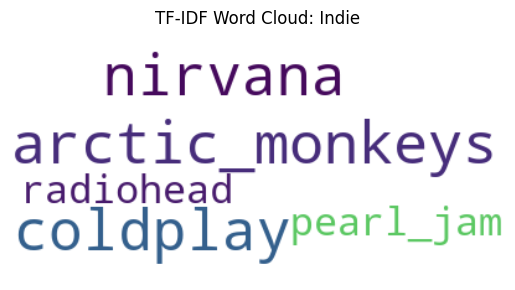

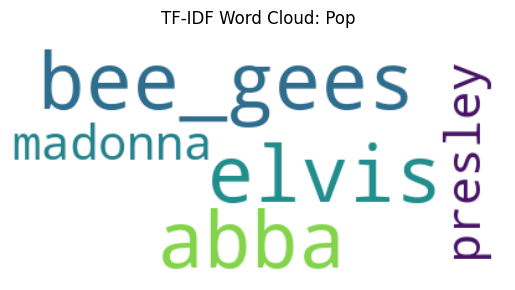

In [10]:
# Part 3: TF-IDF and Word Clouds
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import pandas as pd

# Simulated documents per genre
genre_docs = {
    "Classic": "Beatles Rolling_Stones Eagles Bob_Dylan Queen",
    "Metal": "Metallica Black_Sabbath AC/DC Iron_Maiden Anthrax Slayer",
    "Indie": "Radiohead Nirvana Pearl_Jam Coldplay Arctic_Monkeys",
    "Pop": "Bee_Gees ABBA Madonna Elvis Presley"
}
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(genre_docs.values())
terms = tfidf.get_feature_names_out()
tfidf_matrix = pd.DataFrame(X.toarray(), index=genre_docs.keys(), columns=terms)
print("TF-IDF matrix:\n", tfidf_matrix.round(2))

# Word clouds
for genre, row in tfidf_matrix.iterrows():
    freqs = {term: score for term, score in row.items() if score > 0}
    wc = WordCloud(background_color='white').generate_from_frequencies(freqs)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"TF-IDF Word Cloud: {genre}")
    plt.show()

Part 3 analysis

# Part 4: Sentiment Analysis

In [ ]:
# Part 1: Network Analysis
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter

# Load the rock performer graph
G = nx.read_gexf('./rock_performers_graph.gexf')
print("Directed graph - Nodes:", G.number_of_nodes(), "Edges:", G.number_of_edges())

# Convert to undirected for basic analysis
G_undir = G.to_undirected()


In [ ]:
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

# Fetch text using Wikipedia API and saving as json
def get_wikipedia_text_api(title):
    try:
        encoded_title = urllib.parse.unquote(title)
        URL = "https://en.wikipedia.org/w/api.php"
        PARAMS = {
            "action": "query",
            "prop": "extracts",
            "explaintext": True,
            "titles": encoded_title,
            "format": "json",
            "redirects": 1
        }
        R = requests.get(URL, params=PARAMS, headers={'User-Agent': 'Mozilla/5.0'}, timeout=15)
        if R.status_code != 200 or 'application/json' not in R.headers.get('Content-Type', ''):
            print(f"Non-JSON or error response for {title}: {R.status_code}")
            return ""
        DATA = R.json()
        pages = DATA.get("query", {}).get("pages", {})
        page = next(iter(pages.values()))
        return page.get("extract", "")
    except Exception as e:
        print(f"Failed to fetch {title}: {e}")
        return ""

# Retrieve and store artist texts and sentiment scores
artist_texts = {}
sentiment_scores = {}

for node in G_undir.nodes():
    text = get_wikipedia_text_api(node)
    artist_texts[node] = text
    if text:
        score = sia.polarity_scores(text)['compound']
        sentiment_scores[node] = score
    else:
        sentiment_scores[node] = 0.0
    time.sleep(1)

# Save texts to file
with open('./artist_texts.json', 'w') as f:
    json.dump(artist_texts, f)

# Save sentiment scores to file
with open('./artist_sentiment_scores.json', 'w') as f:
    json.dump(sentiment_scores, f)

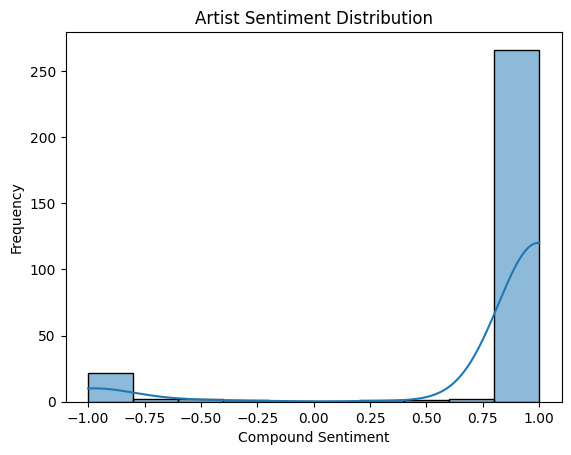

Community 0 average sentiment: 0.92
Community 1 average sentiment: 0.95
Community 2 average sentiment: 0.93
Community 3 average sentiment: 0.66
Community 4 average sentiment: 0.67


In [17]:

#load sentiment scores from file
with open('./artist_sentiment_scores.json', 'r') as f:
    sentiment_scores = json.load(f)

# Histogram of sentiment values
sns.histplot(list(sentiment_scores.values()), bins=10, kde=True)
plt.title("Artist Sentiment Distribution")
plt.xlabel("Compound Sentiment")
plt.ylabel("Frequency")
plt.show()

# Average sentiment per community
comm_sentiment = []
for i, c in enumerate(communities):
    comm_vals = [sentiment_scores[n] for n in c if n in sentiment_scores]
    mean_val = np.mean(comm_vals) if comm_vals else 0
    comm_sentiment.append((i, mean_val))

for i, score in comm_sentiment:
    print(f"Community {i} average sentiment: {score:.2f}")

C:\Users\Mikkel Groengaard\AppData\Local\Temp\ipykernel_21412\48231146.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', len(communities))


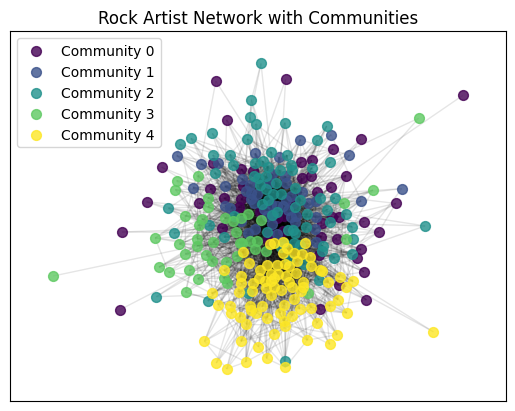

In [18]:
# Visualization of the network with communities
import matplotlib.cm as cm
pos = nx.spring_layout(G_undir, seed=42)
cmap = cm.get_cmap('viridis', len(communities))
for i, community in enumerate(communities):
    nx.draw_networkx_nodes(G_undir, pos,
                           nodelist=list(community),
                           node_color=[cmap(i)],
                           label=f'Community {i}',
                           node_size=50,
                           alpha=0.8)
nx.draw_networkx_edges(G_undir, pos, alpha=0.1)
plt.title("Rock Artist Network with Communities")
plt.legend()
plt.show()

C:\Users\Mikkel Groengaard\AppData\Local\Temp\ipykernel_21412\1453189116.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=comm_indices, y=comm_values, palette='viridis')


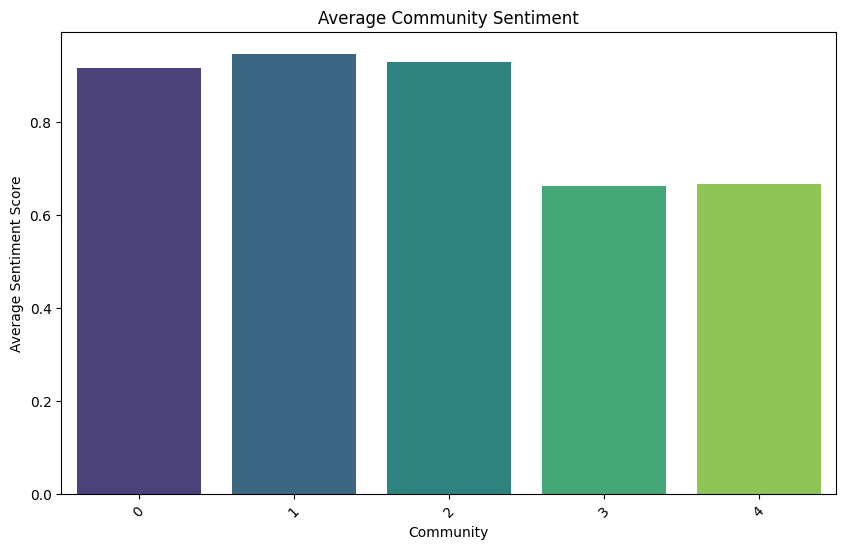

In [19]:
#Plot community sentiment bar chart
comm_indices = [i for i, _ in comm_sentiment]
comm_values = [v for _, v in comm_sentiment]

plt.figure(figsize=(10, 6))
sns.barplot(x=comm_indices, y=comm_values, palette='viridis')
plt.title("Average Community Sentiment")
plt.xlabel("Community")
plt.ylabel("Average Sentiment Score")
plt.xticks(rotation=45)
plt.show()

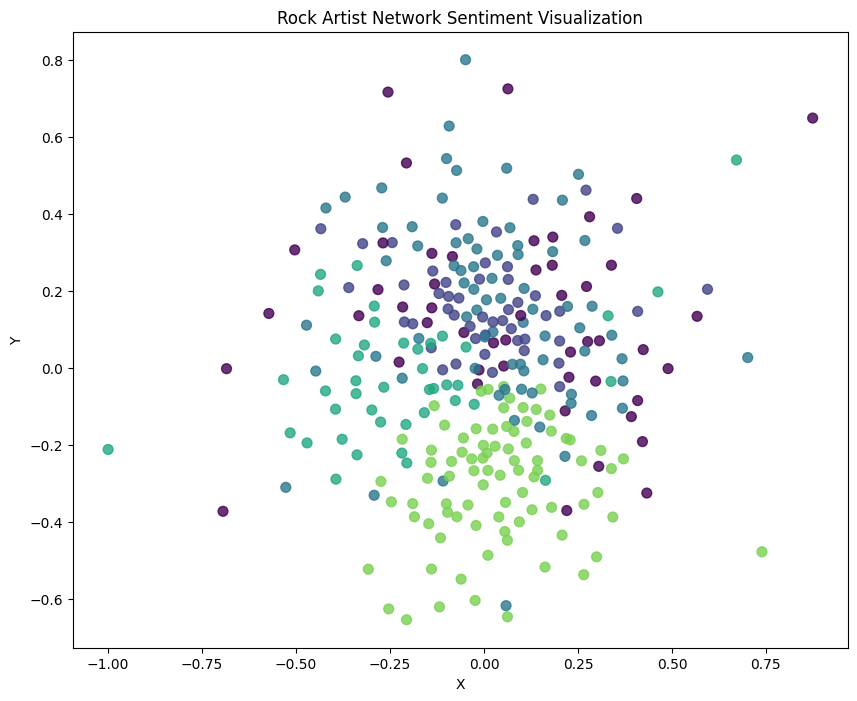

Undirected - Nodes: 297 Edges: 3611


In [ ]:
#Plot sentiment with community colors on the network in a 2D scatter plot
plt.figure(figsize=(10, 8))
pos_array = np.array([pos[n] for n in G_undir.nodes()])
sentiments = np.array([sentiment_scores.get(n, 0) for n in G_undir.nodes()])
comm_colors = np.zeros((len(G_undir.nodes()), 3))
for i, community in enumerate(communities):
    color = cm.viridis(i / len(communities))[:3]
    for node in community:
        idx = list(G_undir.nodes()).index(node)
        comm_colors[idx] = color
plt.scatter(pos_array[:, 0], pos_array[:, 1], c=comm_colors, s=50, alpha=0.8)
plt.title("Rock Artist Network Sentiment Visualization")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


In [21]:
#print the top 5 nodes and bottom 5 nodes by sentiment score of each community
for i, community in enumerate(communities):
    print(f"Community {i}:")
    community_sentiments = [(n, sentiment_scores.get(n, 0)) for n in community]
    top_nodes = sorted(community_sentiments, key=lambda x: x[1], reverse=True)[:5]
    bottom_nodes = sorted(community_sentiments, key=lambda x: x[1])[:5]
    print("  Top 5 nodes:", top_nodes)
    print("  Bottom 5 nodes:", bottom_nodes)

Community 0:
  Top 5 nodes: [('The_Beatles', 1.0), ('The_Cure', 1.0), ('Yes_(band)', 1.0), ('Arctic_Monkeys', 1.0), ('Rock_music', 1.0)]
  Bottom 5 nodes: [('Sex_Pistols', -0.9999), ('The_Jesus_and_Mary_Chain', -0.9973), ('The_Hives', 0.9602), ('Parliament_(band)', 0.9713), ('Modest_Mouse', 0.9732)]
Community 1:
  Top 5 nodes: [('Bee_Gees', 1.0), ('Little_Richard', 1.0), ('Elvis_Costello', 1.0), ('The_Rolling_Stones', 1.0), ('Elvis_Presley', 1.0)]
  Bottom 5 nodes: [('Tom_Petty_and_the_Heartbreakers', -0.9843), ('The_Hollies', 0.6838), ('The_Big_Bopper', 0.8328), ('Canned_Heat', 0.9814), ('Edgar_Winter', 0.9892)]
Community 2:
  Top 5 nodes: [('Green_Day', 1.0), ('Van_Morrison', 1.0), ('Phil_Collins', 1.0), ('Elton_John', 1.0), ('Bon_Jovi', 1.0)]
  Bottom 5 nodes: [('Bread_(band)', -0.9801), ('Gene_Vincent', -0.787), ('Manfred_Mann_Chapter_Three', -0.2263), ('Jim_Croce', 0.8008), ('Everlast', 0.9856)]
Community 3:
  Top 5 nodes: [('Steve_Vai', 1.0), ('Slade', 1.0), ('Bryan_Adams', 1.0),

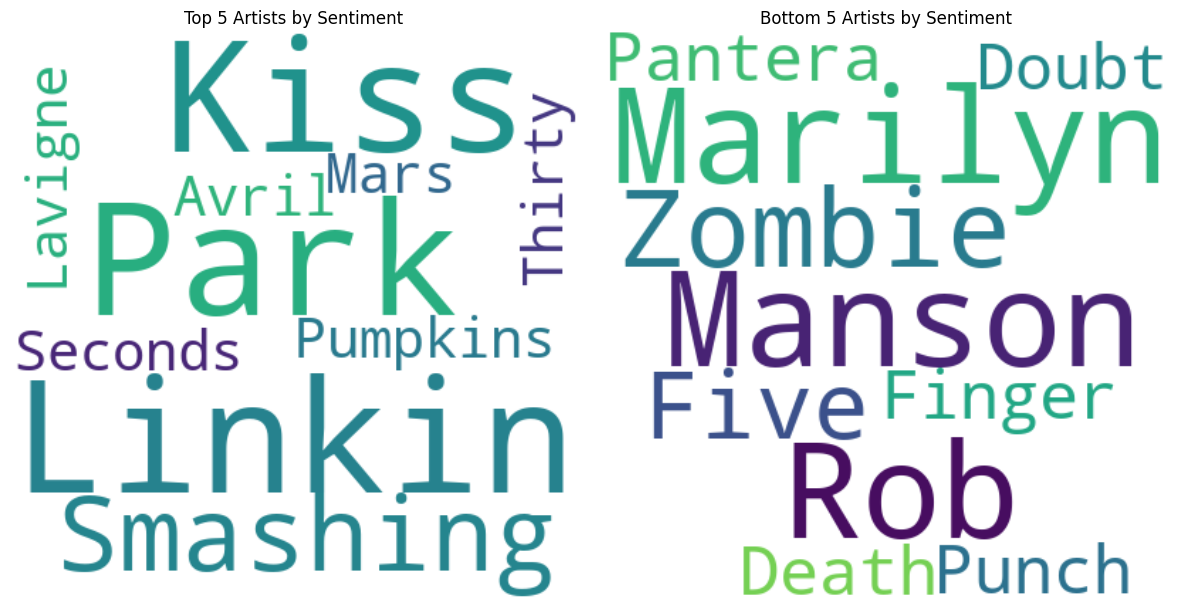

Top 5 by sentiment: [('Linkin_Park', 1.0), ('Kiss_(band)', 1.0), ('The_Smashing_Pumpkins', 1.0), ('Avril_Lavigne', 1.0), ('Thirty_Seconds_to_Mars', 1.0)]
Bottom 5 by sentiment: [('Marilyn_Manson', -0.9999), ('Rob_Zombie', -0.9995), ('Five_Finger_Death_Punch', -0.9993), ('Pantera', -0.9993), ('No_Doubt', -0.9992)]


In [26]:
# Create word clouds for the overall top-5 and bottom-5 artists by sentiment
import re

def clean_label(name):
    return re.sub(r'\s*\(.*?\)', '', name).replace('_', ' ').replace('%26', '&').strip()

# If top_nodes / bottom_nodes not present or you want global, compute from sentiment_scores
try:
    top_nodes  # use existing if present
    bottom_nodes
except NameError:
    sorted_nodes = sorted(sentiment_scores.items(), key=lambda x: x[1], reverse=True)
    top_nodes = sorted_nodes[:5]
    bottom_nodes = sorted_nodes[-5:]

# Helper to get text for an artist (fallback to cleaned name)
def artist_text(node):
    txt = artist_texts.get(node, "") if 'artist_texts' in globals() else ""
    return txt if txt and txt.strip() else clean_label(node)

top_text = " ".join(artist_text(n) for n, _ in top_nodes)
bot_text = " ".join(artist_text(n) for n, _ in bottom_nodes)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
wc_top = WordCloud(width=400, height=400, background_color='white').generate(top_text)
plt.imshow(wc_top, interpolation='bilinear')
plt.axis('off')
plt.title("Top 5 Artists by Sentiment")

plt.subplot(1, 2, 2)
wc_bot = WordCloud(width=400, height=400, background_color='white').generate(bot_text)
plt.imshow(wc_bot, interpolation='bilinear')
plt.axis('off')
plt.title("Bottom 5 Artists by Sentiment")

plt.tight_layout()
plt.show()

# Print the lists used
print("Top 5 by sentiment:", top_nodes)
print("Bottom 5 by sentiment:", bottom_nodes)
